In [36]:
! pip3 install bayesian_optimization
from bayes_opt import BayesianOptimization
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs
import pandas as pd 
import catboost as cb 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import numpy as np
from matplotlib import pyplot as plt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [17]:
train_values = pd.read_csv("train_values.csv", index_col='building_id')
train_values1 = pd.read_csv('Archivos auxiliares KNN/train_values_short1.csv', index_col='building_id')

In [3]:
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [280]:
importances_superestructures = [0.11087213, 0.24814224, 0.06244005, 0.03015171, 0.08679662,
       0.1561809 , 0.0585955 , 0.04264239, 0.07171384, 0.11541968,
       0.01704496]

superestructures = ['has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

reemplazos = {}
for i in range(len(superestructures)):
    reemplazos[superestructures[i]] = {1:importances_superestructures[i]}    

In [281]:
train_values.replace(reemplazos, inplace=True)

In [282]:
train_values['hasnt_secondary'] = (train_values['has_secondary_use'] != True) * 1

In [283]:
importances_secondary_uses = [0.19752775, 0.27044932, 0.21866441, 0.02404361, 0.00476977,
       0.00504387, 0.00198575, 0.00234236, 0.00102254, 0.02242508,
       0.25172554]
secondary_uses =  ['has_secondary_use_agriculture', 'has_secondary_use_hotel',
       'has_secondary_use_rental', 'has_secondary_use_institution',
       'has_secondary_use_school', 'has_secondary_use_industry',
       'has_secondary_use_health_post', 'has_secondary_use_gov_office',
       'has_secondary_use_use_police', 'has_secondary_use_other', 'hasnt_secondary']

reemplazos = {}
for i in range(len(secondary_uses)):
    reemplazos[secondary_uses[i]] = {1:importances_secondary_uses[i]}    

In [284]:
train_values.replace(reemplazos, inplace=True)

In [285]:
train_values ['superestructure'] = train_values\
                .loc[:, superestructures].idxmax(axis='columns')
train_values.drop(columns=superestructures, inplace=True)


train_values ['secondary_use'] = train_values\
                .loc[:, secondary_uses].idxmax(axis='columns')
train_values.drop(columns=secondary_uses, inplace=True)

In [286]:
train_values.drop(columns=["has_secondary_use"], inplace=True)
train_values.drop(columns=[ "geo_level_1_id","geo_level_2_id","geo_level_3_id"], inplace=True)

In [287]:
train_values = train_values.merge(train_values1[["min_geo_id", "max_geo_id"]],right_index=True, left_index=True)

In [294]:
train_values.to_csv('train_values_catboost.csv', index=True)

In [288]:
for col in train_values.columns:
    print(train_values[col].value_counts())

2    156623
3     55617
1     40441
4      5424
5      2246
6       209
7        39
9         1
8         1
Name: count_floors_pre_eq, dtype: int64
10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64
6      42013
7      36752
5      32724
8      28445
9      22199
       ...  
82         1
80         1
78         1
75         1
100        1
Name: area_percentage, Length: 84, dtype: int64
5     78513
6     46477
4     37763
7     35465
3     25957
8     13902
2      9305
9      

In [11]:
# A excepcion de los geo_levels todas las columnas tienen pocos valores por lo que 
# se usar todas como categoricas
categoricas = []
for col in train_values.columns:
    if ((col != 'min_geo_id') & (col != 'max_geo_id')):
        categoricas.append(col)
        categoricas.append(train_values.columns.get_loc(col))
        train_values[col] = train_values[col].astype("category")

In [290]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   count_floors_pre_eq     260601 non-null  category
 1   age                     260601 non-null  category
 2   area_percentage         260601 non-null  category
 3   height_percentage       260601 non-null  category
 4   land_surface_condition  260601 non-null  category
 5   foundation_type         260601 non-null  category
 6   roof_type               260601 non-null  category
 7   ground_floor_type       260601 non-null  category
 8   other_floor_type        260601 non-null  category
 9   position                260601 non-null  category
 10  plan_configuration      260601 non-null  category
 11  legal_ownership_status  260601 non-null  category
 12  count_families          260601 non-null  category
 13  superestructure         260601 non-null  category
 14 

In [13]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, test_size=0.2, random_state=10) 

In [14]:
model = cb.CatBoostClassifier(loss_function='MultiClass', eval_metric='TotalF1', iterations=100) 

In [15]:
model.fit(X_train, y_train, categoricas)

Learning rate set to 0.5
0:	learn: 0.7009538	total: 531ms	remaining: 52.5s
1:	learn: 0.7218660	total: 982ms	remaining: 48.1s
2:	learn: 0.7279061	total: 1.4s	remaining: 45.1s
3:	learn: 0.7334521	total: 1.79s	remaining: 43.1s
4:	learn: 0.7357449	total: 2.22s	remaining: 42.2s
5:	learn: 0.7389619	total: 2.64s	remaining: 41.4s
6:	learn: 0.7396439	total: 3.05s	remaining: 40.6s
7:	learn: 0.7412938	total: 3.49s	remaining: 40.1s
8:	learn: 0.7424586	total: 3.9s	remaining: 39.4s
9:	learn: 0.7428130	total: 4.31s	remaining: 38.8s
10:	learn: 0.7440533	total: 4.71s	remaining: 38.1s
11:	learn: 0.7443327	total: 5.13s	remaining: 37.6s
12:	learn: 0.7453833	total: 5.54s	remaining: 37.1s
13:	learn: 0.7457692	total: 5.96s	remaining: 36.6s
14:	learn: 0.7456499	total: 6.47s	remaining: 36.7s
15:	learn: 0.7462045	total: 6.96s	remaining: 36.5s
16:	learn: 0.7464531	total: 7.38s	remaining: 36s
17:	learn: 0.7469428	total: 7.86s	remaining: 35.8s
18:	learn: 0.7476034	total: 8.33s	remaining: 35.5s
19:	learn: 0.7479908

In [296]:
pred = model.predict(X_test) 
from sklearn.metrics import f1_score
f1_score(pred, y_test, average='micro')

0.7564321482703709

# Tunning

In [2]:
train_values = pd.read_csv('train_values_catboost.csv', index_col='building_id')

In [26]:
# Pruebo otra funcion de perdida
model = cb.CatBoostClassifier(loss_function='MultiClassOneVsAll', eval_metric='TotalF1', iterations=100) 

In [4]:
# A excepcion de los geo_levels todas las columnas tienen pocos valores por lo que 
# se usar todas como categoricas
categoricas = []
for col in train_values.columns:
    if ((col != 'min_geo_id') & (col != 'max_geo_id')):
        categoricas.append(col)
        categoricas.append(train_values.columns.get_loc(col))
        train_values[col] = train_values[col].astype("category")

In [27]:
X_train, X_test, y_train, y_test = train_test_split(train_values, train_labels, test_size=0.2, random_state=10) 

In [ ]:
model.fit(X_train, y_train, categoricas)

In [29]:
pred = model.predict(X_test) 
from sklearn.metrics import f1_score
f1_score(pred, y_test, average='micro')

0.7460332687400472

Los resultados son peores asi que se usara la de antes

# Busqueda de la cantidad de iteraciones

In [ ]:
train_values = pd.read_csv('train_values_catboost.csv', index_col='building_id')
train_labels = pd.read_csv('train_labels.csv', index_col='building_id')

In [ ]:
categoricas = []
for col in train_values.columns:
    if ((col != 'min_geo_id') & (col != 'max_geo_id')):
        categoricas.append(col)
        categoricas.append(train_values.columns.get_loc(col))
        train_values[col] = train_values[col].astype("category")

In [28]:
pool = cb.Pool(data=train_values,
                label=train_labels,
                cat_features=categoricas)

# Para correr en gpu habria que agregar a params
#  "task_type":"GPU"
params = {"loss_function":'MultiClass', "eval_metric":'TotalF1:average=Micro', "iterations":2000,
        "random_seed":2021}
resultados = cb.cv(pool, params, fold_count=10)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

0:	learn: 0.7280671	test: 0.7274606	best: 0.7274606 (0)	total: 20.9s	remaining: 11h 36m 8s
1:	learn: 0.7284073	test: 0.7284123	best: 0.7284123 (1)	total: 40s	remaining: 11h 5m 17s
2:	learn: 0.7318544	test: 0.7315243	best: 0.7315243 (2)	total: 59s	remaining: 10h 54m 43s
3:	learn: 0.7317803	test: 0.7316971	best: 0.7316971 (3)	total: 1m 18s	remaining: 10h 53m 21s
4:	learn: 0.7320177	test: 0.7320578	best: 0.7320578 (4)	total: 1m 42s	remaining: 11h 20m 14s
5:	learn: 0.7324931	test: 0.7322305	best: 0.7322305 (5)	total: 2m	remaining: 11h 9m 8s
6:	learn: 0.7326658	test: 0.7325413	best: 0.7325413 (6)	total: 2m 20s	remaining: 11h 8m 8s
7:	learn: 0.7329506	test: 0.7328867	best: 0.7328867 (7)	total: 2m 44s	remaining: 11h 21m
8:	learn: 0.7334972	test: 0.7337040	best: 0.7337040 (8)	total: 3m 11s	remaining: 11h 45m 27s
9:	learn: 0.7335190	test: 0.7335774	best: 0.7337040 (8)	total: 3m 36s	remaining: 11h 58m 38s
10:	learn: 0.7340715	test: 0.7339726	best: 0.7339726 (10)	total: 4m 2s	remaining: 12h 9m 28

87:	learn: 0.7464272	test: 0.7459373	best: 0.7459373 (87)	total: 30m 36s	remaining: 11h 5m 10s
88:	learn: 0.7465099	test: 0.7460562	best: 0.7460562 (88)	total: 30m 55s	remaining: 11h 4m 10s
89:	learn: 0.7465602	test: 0.7460486	best: 0.7460562 (88)	total: 31m 16s	remaining: 11h 3m 44s
90:	learn: 0.7466088	test: 0.7461867	best: 0.7461867 (90)	total: 31m 37s	remaining: 11h 3m 24s
91:	learn: 0.7466591	test: 0.7463133	best: 0.7463133 (91)	total: 31m 59s	remaining: 11h 3m 19s
92:	learn: 0.7467384	test: 0.7463901	best: 0.7463901 (92)	total: 32m 21s	remaining: 11h 3m 22s
93:	learn: 0.7467857	test: 0.7464208	best: 0.7464208 (93)	total: 32m 42s	remaining: 11h 3m 7s
94:	learn: 0.7468672	test: 0.7465244	best: 0.7465244 (94)	total: 33m 1s	remaining: 11h 2m 12s
95:	learn: 0.7469073	test: 0.7465743	best: 0.7465743 (95)	total: 33m 20s	remaining: 11h 1m 25s
96:	learn: 0.7469512	test: 0.7466510	best: 0.7466510 (96)	total: 33m 42s	remaining: 11h 1m 9s
97:	learn: 0.7470454	test: 0.7467354	best: 0.7467354 

172:	learn: 0.7509581	test: 0.7504576	best: 0.7504576 (172)	total: 59m 52s	remaining: 10h 32m 23s
173:	learn: 0.7509935	test: 0.7505344	best: 0.7505344 (173)	total: 1h 17s	remaining: 10h 32m 42s
174:	learn: 0.7510004	test: 0.7505881	best: 0.7505881 (174)	total: 1h 33s	remaining: 10h 31m 35s
175:	learn: 0.7510605	test: 0.7505459	best: 0.7505881 (174)	total: 1h 53s	remaining: 10h 31m 1s
176:	learn: 0.7510809	test: 0.7505574	best: 0.7505881 (174)	total: 1h 1m 12s	remaining: 10h 30m 29s
177:	learn: 0.7511057	test: 0.7506226	best: 0.7506226 (177)	total: 1h 1m 32s	remaining: 10h 29m 55s
178:	learn: 0.7511202	test: 0.7506571	best: 0.7506571 (178)	total: 1h 1m 49s	remaining: 10h 28m 56s
179:	learn: 0.7511539	test: 0.7506687	best: 0.7506687 (179)	total: 1h 2m 7s	remaining: 10h 28m 7s
180:	learn: 0.7511807	test: 0.7506648	best: 0.7506687 (179)	total: 1h 2m 25s	remaining: 10h 27m 19s
181:	learn: 0.7512118	test: 0.7507262	best: 0.7507262 (181)	total: 1h 2m 43s	remaining: 10h 26m 30s
182:	learn: 0.

255:	learn: 0.7529957	test: 0.7524338	best: 0.7524338 (255)	total: 1h 28m 1s	remaining: 9h 59m 39s
256:	learn: 0.7530188	test: 0.7524914	best: 0.7524914 (256)	total: 1h 28m 22s	remaining: 9h 59m 20s
257:	learn: 0.7530171	test: 0.7524568	best: 0.7524914 (256)	total: 1h 28m 44s	remaining: 9h 59m 11s
258:	learn: 0.7530409	test: 0.7525106	best: 0.7525106 (258)	total: 1h 29m 3s	remaining: 9h 58m 38s
259:	learn: 0.7530588	test: 0.7524261	best: 0.7525106 (258)	total: 1h 29m 23s	remaining: 9h 58m 15s
260:	learn: 0.7530832	test: 0.7524070	best: 0.7525106 (258)	total: 1h 29m 43s	remaining: 9h 57m 46s
261:	learn: 0.7531015	test: 0.7524261	best: 0.7525106 (258)	total: 1h 30m 3s	remaining: 9h 57m 26s
262:	learn: 0.7531296	test: 0.7524453	best: 0.7525106 (258)	total: 1h 30m 23s	remaining: 9h 57m 2s
263:	learn: 0.7531450	test: 0.7524722	best: 0.7525106 (258)	total: 1h 30m 43s	remaining: 9h 56m 32s
264:	learn: 0.7531744	test: 0.7524914	best: 0.7525106 (258)	total: 1h 31m 1s	remaining: 9h 55m 55s
265:	

338:	learn: 0.7542424	test: 0.7533164	best: 0.7533164 (338)	total: 1h 58m 14s	remaining: 9h 39m 20s
339:	learn: 0.7542582	test: 0.7533433	best: 0.7533433 (339)	total: 1h 58m 46s	remaining: 9h 39m 53s
340:	learn: 0.7542923	test: 0.7533663	best: 0.7533663 (340)	total: 1h 59m 13s	remaining: 9h 40m 2s
341:	learn: 0.7543102	test: 0.7533586	best: 0.7533663 (340)	total: 1h 59m 35s	remaining: 9h 39m 46s
342:	learn: 0.7543162	test: 0.7533893	best: 0.7533893 (342)	total: 2h 2s	remaining: 9h 39m 55s
343:	learn: 0.7543132	test: 0.7534200	best: 0.7534200 (343)	total: 2h 25s	remaining: 9h 39m 42s
344:	learn: 0.7543281	test: 0.7534123	best: 0.7534200 (343)	total: 2h 53s	remaining: 9h 39m 54s
345:	learn: 0.7543550	test: 0.7534123	best: 0.7534200 (343)	total: 2h 1m 21s	remaining: 9h 40m 7s
346:	learn: 0.7543691	test: 0.7534469	best: 0.7534469 (346)	total: 2h 1m 46s	remaining: 9h 40m 5s
347:	learn: 0.7543865	test: 0.7534238	best: 0.7534469 (346)	total: 2h 2m 4s	remaining: 9h 39m 29s
348:	learn: 0.754396

421:	learn: 0.7552384	test: 0.7538728	best: 0.7538843 (420)	total: 2h 29m 17s	remaining: 9h 18m 14s
422:	learn: 0.7552742	test: 0.7538997	best: 0.7538997 (422)	total: 2h 29m 50s	remaining: 9h 18m 37s
423:	learn: 0.7552849	test: 0.7538881	best: 0.7538997 (422)	total: 2h 30m 20s	remaining: 9h 18m 48s
424:	learn: 0.7552998	test: 0.7538536	best: 0.7538997 (422)	total: 2h 30m 45s	remaining: 9h 18m 42s
425:	learn: 0.7553118	test: 0.7538881	best: 0.7538997 (422)	total: 2h 31m 15s	remaining: 9h 18m 51s
426:	learn: 0.7553275	test: 0.7539188	best: 0.7539188 (426)	total: 2h 31m 54s	remaining: 9h 19m 34s
427:	learn: 0.7553382	test: 0.7539112	best: 0.7539188 (426)	total: 2h 32m 25s	remaining: 9h 19m 50s
428:	learn: 0.7553395	test: 0.7539035	best: 0.7539188 (426)	total: 2h 32m 56s	remaining: 9h 20m 2s
429:	learn: 0.7553523	test: 0.7538843	best: 0.7539188 (426)	total: 2h 33m 28s	remaining: 9h 20m 22s
430:	learn: 0.7553693	test: 0.7539495	best: 0.7539495 (430)	total: 2h 34m 2s	remaining: 9h 20m 44s
43

504:	learn: 0.7560860	test: 0.7544599	best: 0.7544599 (504)	total: 3h 5m 31s	remaining: 9h 9m 14s
505:	learn: 0.7561150	test: 0.7545021	best: 0.7545021 (505)	total: 3h 5m 55s	remaining: 9h 8m 58s
506:	learn: 0.7561116	test: 0.7545098	best: 0.7545098 (506)	total: 3h 6m 16s	remaining: 9h 8m 31s
507:	learn: 0.7561057	test: 0.7544714	best: 0.7545098 (506)	total: 3h 6m 37s	remaining: 9h 8m 6s
508:	learn: 0.7561223	test: 0.7544676	best: 0.7545098 (506)	total: 3h 7m	remaining: 9h 7m 47s
509:	learn: 0.7561312	test: 0.7544522	best: 0.7545098 (506)	total: 3h 7m 25s	remaining: 9h 7m 34s
510:	learn: 0.7561445	test: 0.7544714	best: 0.7545098 (506)	total: 3h 7m 45s	remaining: 9h 7m 7s
511:	learn: 0.7561474	test: 0.7544676	best: 0.7545098 (506)	total: 3h 8m 6s	remaining: 9h 6m 41s
512:	learn: 0.7561649	test: 0.7545098	best: 0.7545098 (506)	total: 3h 8m 26s	remaining: 9h 6m 13s
513:	learn: 0.7561636	test: 0.7545021	best: 0.7545098 (506)	total: 3h 8m 48s	remaining: 9h 5m 50s
514:	learn: 0.7561679	test:

587:	learn: 0.7566284	test: 0.7548206	best: 0.7548321 (576)	total: 3h 35m	remaining: 8h 36m 19s
588:	learn: 0.7566399	test: 0.7547784	best: 0.7548321 (576)	total: 3h 35m 25s	remaining: 8h 36m 4s
589:	learn: 0.7566442	test: 0.7548206	best: 0.7548321 (576)	total: 3h 35m 49s	remaining: 8h 35m 47s
590:	learn: 0.7566476	test: 0.7548091	best: 0.7548321 (576)	total: 3h 36m 7s	remaining: 8h 35m 14s
591:	learn: 0.7566791	test: 0.7547937	best: 0.7548321 (576)	total: 3h 36m 27s	remaining: 8h 34m 49s
592:	learn: 0.7566791	test: 0.7548244	best: 0.7548321 (576)	total: 3h 36m 51s	remaining: 8h 34m 31s
593:	learn: 0.7566778	test: 0.7547746	best: 0.7548321 (576)	total: 3h 37m 12s	remaining: 8h 34m 7s
594:	learn: 0.7566949	test: 0.7547861	best: 0.7548321 (576)	total: 3h 37m 34s	remaining: 8h 33m 45s
595:	learn: 0.7566932	test: 0.7547477	best: 0.7548321 (576)	total: 3h 37m 55s	remaining: 8h 33m 20s
596:	learn: 0.7567051	test: 0.7547976	best: 0.7548321 (576)	total: 3h 38m 15s	remaining: 8h 32m 55s
597:	le

670:	learn: 0.7571230	test: 0.7550086	best: 0.7550662 (662)	total: 4h 4m 14s	remaining: 8h 3m 45s
671:	learn: 0.7571251	test: 0.7550278	best: 0.7550662 (662)	total: 4h 4m 31s	remaining: 8h 3m 14s
672:	learn: 0.7571357	test: 0.7550739	best: 0.7550739 (672)	total: 4h 4m 52s	remaining: 8h 2m 49s
673:	learn: 0.7571349	test: 0.7550854	best: 0.7550854 (673)	total: 4h 5m 12s	remaining: 8h 2m 24s
674:	learn: 0.7571311	test: 0.7550777	best: 0.7550854 (673)	total: 4h 5m 31s	remaining: 8h 1m 57s
675:	learn: 0.7571362	test: 0.7551007	best: 0.7551007 (675)	total: 4h 5m 50s	remaining: 8h 1m 30s
676:	learn: 0.7571362	test: 0.7550662	best: 0.7551007 (675)	total: 4h 6m 12s	remaining: 8h 1m 8s
677:	learn: 0.7571413	test: 0.7551084	best: 0.7551084 (677)	total: 4h 6m 31s	remaining: 8h 41s
678:	learn: 0.7571383	test: 0.7551314	best: 0.7551314 (678)	total: 4h 6m 51s	remaining: 8h 14s
679:	learn: 0.7571396	test: 0.7551007	best: 0.7551314 (678)	total: 4h 7m 12s	remaining: 7h 59m 52s
680:	learn: 0.7571439	test

753:	learn: 0.7574589	test: 0.7551199	best: 0.7551583 (748)	total: 4h 32m 53s	remaining: 7h 30m 57s
754:	learn: 0.7574730	test: 0.7551353	best: 0.7551583 (748)	total: 4h 33m 16s	remaining: 7h 30m 37s
755:	learn: 0.7574722	test: 0.7551391	best: 0.7551583 (748)	total: 4h 33m 38s	remaining: 7h 30m 16s
756:	learn: 0.7574704	test: 0.7551391	best: 0.7551583 (748)	total: 4h 33m 59s	remaining: 7h 29m 53s
757:	learn: 0.7574713	test: 0.7551506	best: 0.7551583 (748)	total: 4h 34m 19s	remaining: 7h 29m 29s
758:	learn: 0.7574820	test: 0.7551429	best: 0.7551583 (748)	total: 4h 34m 39s	remaining: 7h 29m 5s
759:	learn: 0.7574896	test: 0.7551007	best: 0.7551583 (748)	total: 4h 35m	remaining: 7h 28m 42s
760:	learn: 0.7574918	test: 0.7551199	best: 0.7551583 (748)	total: 4h 35m 21s	remaining: 7h 28m 19s
761:	learn: 0.7574990	test: 0.7551391	best: 0.7551583 (748)	total: 4h 35m 40s	remaining: 7h 27m 53s
762:	learn: 0.7575041	test: 0.7551660	best: 0.7551660 (762)	total: 4h 36m	remaining: 7h 27m 28s
763:	lear

836:	learn: 0.7577855	test: 0.7554077	best: 0.7554077 (836)	total: 5h 50s	remaining: 6h 58m 1s
837:	learn: 0.7577825	test: 0.7553808	best: 0.7554077 (836)	total: 5h 1m 10s	remaining: 6h 57m 36s
838:	learn: 0.7577911	test: 0.7553501	best: 0.7554077 (836)	total: 5h 1m 30s	remaining: 6h 57m 13s
839:	learn: 0.7577894	test: 0.7553463	best: 0.7554077 (836)	total: 5h 1m 52s	remaining: 6h 56m 51s
840:	learn: 0.7577970	test: 0.7553617	best: 0.7554077 (836)	total: 5h 2m 11s	remaining: 6h 56m 26s
841:	learn: 0.7578017	test: 0.7554154	best: 0.7554154 (841)	total: 5h 2m 29s	remaining: 6h 56m
842:	learn: 0.7578218	test: 0.7554269	best: 0.7554269 (842)	total: 5h 2m 49s	remaining: 6h 55m 37s
843:	learn: 0.7578346	test: 0.7554039	best: 0.7554269 (842)	total: 5h 3m 9s	remaining: 6h 55m 13s
844:	learn: 0.7578367	test: 0.7554000	best: 0.7554269 (842)	total: 5h 3m 29s	remaining: 6h 54m 49s
845:	learn: 0.7578294	test: 0.7553962	best: 0.7554269 (842)	total: 5h 3m 49s	remaining: 6h 54m 25s
846:	learn: 0.75783

919:	learn: 0.7581322	test: 0.7555574	best: 0.7556149 (910)	total: 5h 28m 16s	remaining: 6h 25m 22s
920:	learn: 0.7581347	test: 0.7555957	best: 0.7556149 (910)	total: 5h 28m 33s	remaining: 6h 24m 55s
921:	learn: 0.7581432	test: 0.7556149	best: 0.7556149 (910)	total: 5h 28m 57s	remaining: 6h 24m 36s
922:	learn: 0.7581441	test: 0.7556188	best: 0.7556188 (922)	total: 5h 29m 14s	remaining: 6h 24m 10s
923:	learn: 0.7581437	test: 0.7556188	best: 0.7556188 (922)	total: 5h 29m 40s	remaining: 6h 23m 54s
924:	learn: 0.7581484	test: 0.7556111	best: 0.7556188 (922)	total: 5h 30m 2s	remaining: 6h 23m 33s
925:	learn: 0.7581496	test: 0.7556341	best: 0.7556341 (925)	total: 5h 30m 26s	remaining: 6h 23m 15s
926:	learn: 0.7581603	test: 0.7556341	best: 0.7556341 (926)	total: 5h 30m 45s	remaining: 6h 22m 51s
927:	learn: 0.7581624	test: 0.7556149	best: 0.7556341 (926)	total: 5h 31m 6s	remaining: 6h 22m 28s
928:	learn: 0.7581582	test: 0.7556149	best: 0.7556341 (926)	total: 5h 31m 27s	remaining: 6h 22m 7s
929

1002:	learn: 0.7584110	test: 0.7556495	best: 0.7556878 (977)	total: 5h 55m 48s	remaining: 5h 53m 40s
1003:	learn: 0.7584093	test: 0.7556571	best: 0.7556878 (977)	total: 5h 56m 9s	remaining: 5h 53m 19s
1004:	learn: 0.7584242	test: 0.7556840	best: 0.7556878 (977)	total: 5h 56m 31s	remaining: 5h 52m 58s
1005:	learn: 0.7584293	test: 0.7557147	best: 0.7557147 (1005)	total: 5h 56m 53s	remaining: 5h 52m 37s
1006:	learn: 0.7584353	test: 0.7557109	best: 0.7557147 (1005)	total: 5h 57m 16s	remaining: 5h 52m 18s
1007:	learn: 0.7584396	test: 0.7557109	best: 0.7557147 (1005)	total: 5h 57m 37s	remaining: 5h 51m 56s
1008:	learn: 0.7584507	test: 0.7556763	best: 0.7557147 (1005)	total: 5h 57m 58s	remaining: 5h 51m 34s
1009:	learn: 0.7584562	test: 0.7556686	best: 0.7557147 (1005)	total: 5h 58m 24s	remaining: 5h 51m 18s
1010:	learn: 0.7584528	test: 0.7556495	best: 0.7557147 (1005)	total: 5h 58m 46s	remaining: 5h 50m 58s
1011:	learn: 0.7584515	test: 0.7556418	best: 0.7557147 (1005)	total: 5h 59m 4s	remaini

1084:	learn: 0.7587265	test: 0.7557799	best: 0.7558068 (1071)	total: 6h 23m 27s	remaining: 5h 23m 22s
1085:	learn: 0.7587223	test: 0.7557722	best: 0.7558068 (1071)	total: 6h 23m 47s	remaining: 5h 23m
1086:	learn: 0.7587235	test: 0.7557646	best: 0.7558068 (1071)	total: 6h 24m 5s	remaining: 5h 22m 36s
1087:	learn: 0.7587308	test: 0.7557339	best: 0.7558068 (1071)	total: 6h 24m 25s	remaining: 5h 22m 14s
1088:	learn: 0.7587329	test: 0.7557415	best: 0.7558068 (1071)	total: 6h 24m 44s	remaining: 5h 21m 51s
1089:	learn: 0.7587410	test: 0.7557224	best: 0.7558068 (1071)	total: 6h 25m 8s	remaining: 5h 21m 32s
1090:	learn: 0.7587436	test: 0.7557300	best: 0.7558068 (1071)	total: 6h 25m 29s	remaining: 5h 21m 11s
1091:	learn: 0.7587542	test: 0.7557300	best: 0.7558068 (1071)	total: 6h 25m 53s	remaining: 5h 20m 52s
1092:	learn: 0.7587589	test: 0.7557377	best: 0.7558068 (1071)	total: 6h 26m 12s	remaining: 5h 20m 29s
1093:	learn: 0.7587636	test: 0.7557377	best: 0.7558068 (1071)	total: 6h 26m 32s	remainin

1166:	learn: 0.7589875	test: 0.7558375	best: 0.7558452 (1164)	total: 6h 50m 52s	remaining: 4h 53m 16s
1167:	learn: 0.7589913	test: 0.7558375	best: 0.7558452 (1164)	total: 6h 51m 11s	remaining: 4h 52m 54s
1168:	learn: 0.7589921	test: 0.7558375	best: 0.7558452 (1164)	total: 6h 51m 31s	remaining: 4h 52m 32s
1169:	learn: 0.7590041	test: 0.7558260	best: 0.7558452 (1164)	total: 6h 51m 50s	remaining: 4h 52m 9s
1170:	learn: 0.7590032	test: 0.7558375	best: 0.7558452 (1164)	total: 6h 52m 9s	remaining: 4h 51m 47s
1171:	learn: 0.7590164	test: 0.7558336	best: 0.7558452 (1164)	total: 6h 52m 27s	remaining: 4h 51m 23s
1172:	learn: 0.7590173	test: 0.7558490	best: 0.7558490 (1172)	total: 6h 52m 47s	remaining: 4h 51m 1s
1173:	learn: 0.7590169	test: 0.7558643	best: 0.7558643 (1173)	total: 6h 53m 8s	remaining: 4h 50m 40s
1174:	learn: 0.7590207	test: 0.7558759	best: 0.7558759 (1174)	total: 6h 53m 31s	remaining: 4h 50m 20s
1175:	learn: 0.7590352	test: 0.7558682	best: 0.7558759 (1174)	total: 6h 53m 51s	remain

1247:	learn: 0.7591934	test: 0.7558950	best: 0.7559181 (1245)	total: 7h 18m 5s	remaining: 4h 23m 58s
1248:	learn: 0.7591959	test: 0.7558759	best: 0.7559181 (1245)	total: 7h 18m 24s	remaining: 4h 23m 36s
1249:	learn: 0.7591981	test: 0.7558682	best: 0.7559181 (1245)	total: 7h 18m 41s	remaining: 4h 23m 13s
1250:	learn: 0.7591947	test: 0.7558759	best: 0.7559181 (1245)	total: 7h 19m 2s	remaining: 4h 22m 51s
1251:	learn: 0.7591908	test: 0.7558605	best: 0.7559181 (1245)	total: 7h 19m 23s	remaining: 4h 22m 30s
1252:	learn: 0.7591930	test: 0.7558490	best: 0.7559181 (1245)	total: 7h 19m 43s	remaining: 4h 22m 8s
1253:	learn: 0.7592028	test: 0.7558605	best: 0.7559181 (1245)	total: 7h 20m 5s	remaining: 4h 21m 48s
1254:	learn: 0.7592121	test: 0.7558452	best: 0.7559181 (1245)	total: 7h 20m 24s	remaining: 4h 21m 26s
1255:	learn: 0.7592156	test: 0.7558567	best: 0.7559181 (1245)	total: 7h 20m 39s	remaining: 4h 21m 1s
1256:	learn: 0.7592202	test: 0.7558682	best: 0.7559181 (1245)	total: 7h 20m 58s	remaini

1328:	learn: 0.7594556	test: 0.7558567	best: 0.7559181 (1245)	total: 7h 45m 15s	remaining: 3h 54m 54s
1329:	learn: 0.7594556	test: 0.7558567	best: 0.7559181 (1245)	total: 7h 45m 32s	remaining: 3h 54m 31s
1330:	learn: 0.7594620	test: 0.7558452	best: 0.7559181 (1245)	total: 7h 45m 53s	remaining: 3h 54m 10s
1331:	learn: 0.7594650	test: 0.7558413	best: 0.7559181 (1245)	total: 7h 46m 11s	remaining: 3h 53m 47s
1332:	learn: 0.7594611	test: 0.7558452	best: 0.7559181 (1245)	total: 7h 46m 31s	remaining: 3h 53m 26s
1333:	learn: 0.7594599	test: 0.7558567	best: 0.7559181 (1245)	total: 7h 46m 50s	remaining: 3h 53m 4s
1334:	learn: 0.7594590	test: 0.7558605	best: 0.7559181 (1245)	total: 7h 47m 9s	remaining: 3h 52m 42s
1335:	learn: 0.7594637	test: 0.7558605	best: 0.7559181 (1245)	total: 7h 47m 28s	remaining: 3h 52m 20s
1336:	learn: 0.7594675	test: 0.7558989	best: 0.7559181 (1245)	total: 7h 47m 47s	remaining: 3h 51m 58s
1337:	learn: 0.7594752	test: 0.7558835	best: 0.7559181 (1245)	total: 7h 48m 9s	remai

1410:	learn: 0.7596875	test: 0.7559871	best: 0.7560178 (1387)	total: 8h 12m 32s	remaining: 3h 25m 36s
1411:	learn: 0.7597016	test: 0.7560063	best: 0.7560178 (1387)	total: 8h 12m 53s	remaining: 3h 25m 15s
1412:	learn: 0.7597127	test: 0.7560217	best: 0.7560217 (1412)	total: 8h 13m 11s	remaining: 3h 24m 53s
1413:	learn: 0.7597161	test: 0.7559986	best: 0.7560217 (1412)	total: 8h 13m 33s	remaining: 3h 24m 32s
1414:	learn: 0.7597089	test: 0.7559948	best: 0.7560217 (1412)	total: 8h 13m 53s	remaining: 3h 24m 11s
1415:	learn: 0.7597042	test: 0.7560025	best: 0.7560217 (1412)	total: 8h 14m 13s	remaining: 3h 23m 50s
1416:	learn: 0.7597093	test: 0.7560370	best: 0.7560370 (1416)	total: 8h 14m 32s	remaining: 3h 23m 28s
1417:	learn: 0.7597199	test: 0.7560332	best: 0.7560370 (1416)	total: 8h 14m 53s	remaining: 3h 23m 7s
1418:	learn: 0.7597217	test: 0.7560600	best: 0.7560600 (1418)	total: 8h 15m 10s	remaining: 3h 22m 44s
1419:	learn: 0.7597174	test: 0.7560485	best: 0.7560600 (1418)	total: 8h 15m 27s	rem

1492:	learn: 0.7599024	test: 0.7560754	best: 0.7561253 (1442)	total: 8h 39m 52s	remaining: 2h 56m 32s
1493:	learn: 0.7598960	test: 0.7560946	best: 0.7561253 (1442)	total: 8h 40m 12s	remaining: 2h 56m 11s
1494:	learn: 0.7598982	test: 0.7560946	best: 0.7561253 (1442)	total: 8h 40m 34s	remaining: 2h 55m 50s
1495:	learn: 0.7599084	test: 0.7560831	best: 0.7561253 (1442)	total: 8h 40m 54s	remaining: 2h 55m 29s
1496:	learn: 0.7599131	test: 0.7560639	best: 0.7561253 (1442)	total: 8h 41m 17s	remaining: 2h 55m 9s
1497:	learn: 0.7599037	test: 0.7560907	best: 0.7561253 (1442)	total: 8h 41m 38s	remaining: 2h 54m 48s
1498:	learn: 0.7599174	test: 0.7561061	best: 0.7561253 (1442)	total: 8h 41m 58s	remaining: 2h 54m 27s
1499:	learn: 0.7599246	test: 0.7561253	best: 0.7561253 (1442)	total: 8h 42m 18s	remaining: 2h 54m 6s
1500:	learn: 0.7599229	test: 0.7561099	best: 0.7561253 (1442)	total: 8h 42m 39s	remaining: 2h 53m 45s
1501:	learn: 0.7599152	test: 0.7561061	best: 0.7561253 (1442)	total: 8h 42m 57s	rema

1573:	learn: 0.7601250	test: 0.7561138	best: 0.7561291 (1572)	total: 9h 7m 9s	remaining: 2h 28m 5s
1574:	learn: 0.7601207	test: 0.7561253	best: 0.7561291 (1572)	total: 9h 7m 32s	remaining: 2h 27m 44s
1575:	learn: 0.7601318	test: 0.7561329	best: 0.7561329 (1575)	total: 9h 7m 55s	remaining: 2h 27m 24s
1576:	learn: 0.7601318	test: 0.7561291	best: 0.7561329 (1575)	total: 9h 8m 14s	remaining: 2h 27m 3s
1577:	learn: 0.7601374	test: 0.7561368	best: 0.7561368 (1577)	total: 9h 8m 32s	remaining: 2h 26m 41s
1578:	learn: 0.7601429	test: 0.7561253	best: 0.7561368 (1577)	total: 9h 8m 50s	remaining: 2h 26m 20s
1579:	learn: 0.7601467	test: 0.7561176	best: 0.7561368 (1577)	total: 9h 9m 9s	remaining: 2h 25m 58s
1580:	learn: 0.7601497	test: 0.7561138	best: 0.7561368 (1577)	total: 9h 9m 29s	remaining: 2h 25m 37s
1581:	learn: 0.7601583	test: 0.7561138	best: 0.7561368 (1577)	total: 9h 9m 49s	remaining: 2h 25m 16s
1582:	learn: 0.7601685	test: 0.7561521	best: 0.7561521 (1582)	total: 9h 10m 10s	remaining: 2h 2

1655:	learn: 0.7603343	test: 0.7561176	best: 0.7562135 (1626)	total: 9h 34m 33s	remaining: 1h 59m 21s
1656:	learn: 0.7603386	test: 0.7561176	best: 0.7562135 (1626)	total: 9h 34m 50s	remaining: 1h 58m 59s
1657:	learn: 0.7603424	test: 0.7561291	best: 0.7562135 (1626)	total: 9h 35m 11s	remaining: 1h 58m 38s
1658:	learn: 0.7603446	test: 0.7561214	best: 0.7562135 (1626)	total: 9h 35m 27s	remaining: 1h 58m 17s
1659:	learn: 0.7603459	test: 0.7561099	best: 0.7562135 (1626)	total: 9h 35m 45s	remaining: 1h 57m 55s
1660:	learn: 0.7603505	test: 0.7561176	best: 0.7562135 (1626)	total: 9h 36m 3s	remaining: 1h 57m 34s
1661:	learn: 0.7603544	test: 0.7561521	best: 0.7562135 (1626)	total: 9h 36m 23s	remaining: 1h 57m 13s
1662:	learn: 0.7603531	test: 0.7561598	best: 0.7562135 (1626)	total: 9h 36m 43s	remaining: 1h 56m 52s
1663:	learn: 0.7603561	test: 0.7561521	best: 0.7562135 (1626)	total: 9h 37m 1s	remaining: 1h 56m 30s
1664:	learn: 0.7603531	test: 0.7561330	best: 0.7562135 (1626)	total: 9h 37m 20s	rema

1736:	learn: 0.7605974	test: 0.7562749	best: 0.7562749 (1736)	total: 10h 1m 20s	remaining: 1h 31m 2s
1737:	learn: 0.7606021	test: 0.7562788	best: 0.7562788 (1737)	total: 10h 1m 38s	remaining: 1h 30m 41s
1738:	learn: 0.7606038	test: 0.7562711	best: 0.7562788 (1737)	total: 10h 1m 57s	remaining: 1h 30m 20s
1739:	learn: 0.7606017	test: 0.7562864	best: 0.7562864 (1739)	total: 10h 2m 17s	remaining: 1h 29m 59s
1740:	learn: 0.7606051	test: 0.7562941	best: 0.7562941 (1740)	total: 10h 2m 37s	remaining: 1h 29m 39s
1741:	learn: 0.7606157	test: 0.7562980	best: 0.7562980 (1741)	total: 10h 2m 58s	remaining: 1h 29m 18s
1742:	learn: 0.7606209	test: 0.7562749	best: 0.7562980 (1741)	total: 10h 3m 16s	remaining: 1h 28m 57s
1743:	learn: 0.7606213	test: 0.7562749	best: 0.7562980 (1741)	total: 10h 3m 38s	remaining: 1h 28m 36s
1744:	learn: 0.7606174	test: 0.7562557	best: 0.7562980 (1741)	total: 10h 3m 56s	remaining: 1h 28m 15s
1745:	learn: 0.7606243	test: 0.7562634	best: 0.7562980 (1741)	total: 10h 4m 14s	rem

1817:	learn: 0.7608166	test: 0.7562404	best: 0.7562980 (1770)	total: 10h 28m 10s	remaining: 1h 2m 53s
1818:	learn: 0.7608131	test: 0.7562481	best: 0.7562980 (1770)	total: 10h 28m 29s	remaining: 1h 2m 32s
1819:	learn: 0.7608157	test: 0.7562250	best: 0.7562980 (1770)	total: 10h 28m 49s	remaining: 1h 2m 11s
1820:	learn: 0.7608264	test: 0.7562250	best: 0.7562980 (1770)	total: 10h 29m 9s	remaining: 1h 1m 50s
1821:	learn: 0.7608264	test: 0.7562289	best: 0.7562980 (1770)	total: 10h 29m 27s	remaining: 1h 1m 29s
1822:	learn: 0.7608264	test: 0.7562327	best: 0.7562980 (1770)	total: 10h 29m 44s	remaining: 1h 1m 8s
1823:	learn: 0.7608276	test: 0.7562212	best: 0.7562980 (1770)	total: 10h 30m 2s	remaining: 1h 47s
1824:	learn: 0.7608298	test: 0.7562135	best: 0.7562980 (1770)	total: 10h 30m 21s	remaining: 1h 26s
1825:	learn: 0.7608323	test: 0.7562366	best: 0.7562980 (1770)	total: 10h 30m 41s	remaining: 1h 5s
1826:	learn: 0.7608404	test: 0.7562059	best: 0.7562980 (1770)	total: 10h 31m	remaining: 59m 45s

1900:	learn: 0.7610268	test: 0.7563517	best: 0.7563785 (1895)	total: 10h 56m 3s	remaining: 34m 9s
1901:	learn: 0.7610387	test: 0.7563555	best: 0.7563785 (1895)	total: 10h 56m 26s	remaining: 33m 49s
1902:	learn: 0.7610464	test: 0.7563517	best: 0.7563785 (1895)	total: 10h 56m 45s	remaining: 33m 28s
1903:	learn: 0.7610549	test: 0.7563440	best: 0.7563785 (1895)	total: 10h 57m 7s	remaining: 33m 7s
1904:	learn: 0.7610575	test: 0.7563325	best: 0.7563785 (1895)	total: 10h 57m 24s	remaining: 32m 47s
1905:	learn: 0.7610626	test: 0.7563440	best: 0.7563785 (1895)	total: 10h 57m 42s	remaining: 32m 26s
1906:	learn: 0.7610634	test: 0.7563440	best: 0.7563785 (1895)	total: 10h 57m 59s	remaining: 32m 5s
1907:	learn: 0.7610592	test: 0.7563478	best: 0.7563785 (1895)	total: 10h 58m 21s	remaining: 31m 44s
1908:	learn: 0.7610711	test: 0.7563325	best: 0.7563785 (1895)	total: 10h 58m 40s	remaining: 31m 23s
1909:	learn: 0.7610737	test: 0.7563440	best: 0.7563785 (1895)	total: 10h 59m 1s	remaining: 31m 3s
1910:	l

1983:	learn: 0.7612881	test: 0.7563824	best: 0.7564207 (1969)	total: 11h 24m 4s	remaining: 5m 31s
1984:	learn: 0.7612971	test: 0.7563785	best: 0.7564207 (1969)	total: 11h 24m 25s	remaining: 5m 10s
1985:	learn: 0.7612920	test: 0.7563632	best: 0.7564207 (1969)	total: 11h 24m 47s	remaining: 4m 49s
1986:	learn: 0.7613013	test: 0.7563785	best: 0.7564207 (1969)	total: 11h 25m 9s	remaining: 4m 28s
1987:	learn: 0.7613082	test: 0.7563747	best: 0.7564207 (1969)	total: 11h 25m 29s	remaining: 4m 8s
1988:	learn: 0.7613137	test: 0.7563824	best: 0.7564207 (1969)	total: 11h 25m 48s	remaining: 3m 47s
1989:	learn: 0.7613171	test: 0.7564131	best: 0.7564207 (1969)	total: 11h 26m 7s	remaining: 3m 26s
1990:	learn: 0.7613239	test: 0.7563862	best: 0.7564207 (1969)	total: 11h 26m 27s	remaining: 3m 6s
1991:	learn: 0.7613278	test: 0.7563900	best: 0.7564207 (1969)	total: 11h 26m 51s	remaining: 2m 45s
1992:	learn: 0.7613359	test: 0.7564016	best: 0.7564207 (1969)	total: 11h 27m 14s	remaining: 2m 24s
1993:	learn: 0.

In [30]:
resultados["test-TotalF1:average=Micro-mean"].idxmax()

1999

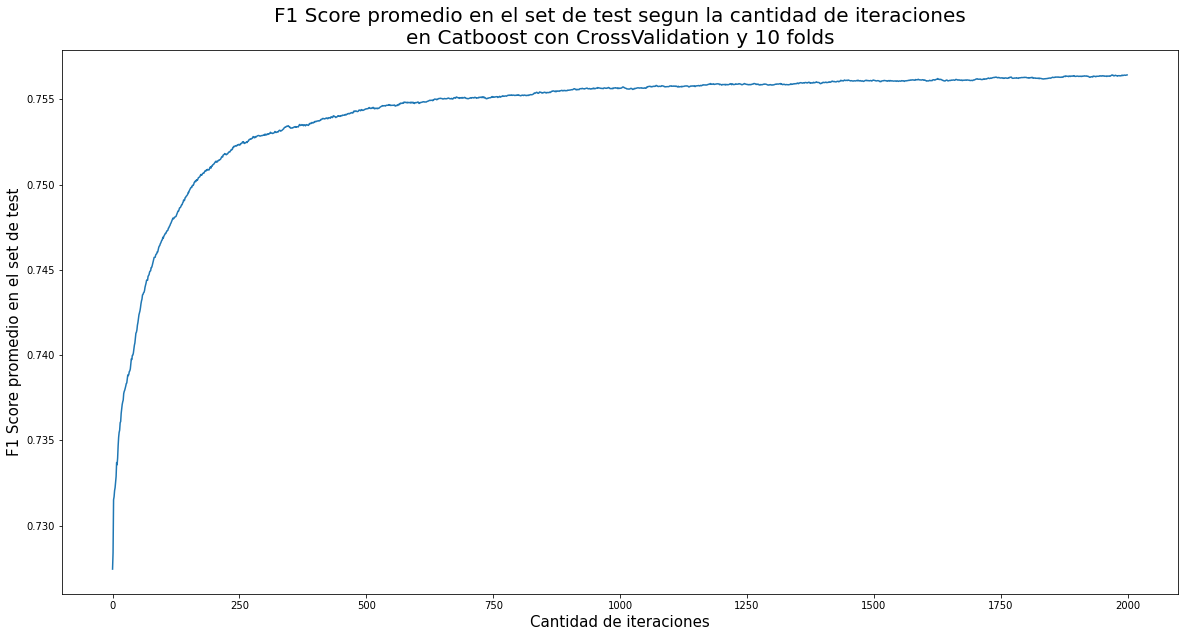

In [69]:
plt.plot(resultados['iterations'],resultados["test-TotalF1:average=Micro-mean"])
plt.xlabel("Cantidad de iteraciones",  fontsize=15)
plt.ylabel("F1 Score promedio en el set de test",  fontsize=15)
plt.title('F1 Score promedio en el set de test segun la cantidad de iteraciones\n'
         "en Catboost con CrossValidation y 10 folds",  fontsize=20)
plt.show()